In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from functools import reduce

In [2]:
fontsize = 16
lw = 2

In [3]:
path1 = '01_Data/00_Reports/DIANN180/'
path2 = '01_Data/00_Reports/Spec18/'

names = ['indiv', 'mbr', 
         '+1_5', '+5_5', '+10_5', '+100_5',
         '+1_10', '+5_10', '+10_10', '+100_10',
         '+1_20', '+5_20', '+10_20', '+100_20']

dnn_reports = []
spec_reports = []

# for diann
indiv_reports = []
for i in range(7):
    frame = pd.read_csv(path1 + 'r' + str(i+1) + '_report.tsv', sep='\t')
    indiv_reports.append(frame)
    
dnn_reports.append(pd.concat(indiv_reports))

for name in names:
    if name != 'indiv':
        frame = pd.read_csv(path1 + name + '_report.tsv', sep='\t')
        dnn_reports.append(frame)

# for spectronaut
indiv_reports = []
for i in range(7):
    frame = pd.read_csv(path2 + 'r' + str(i+1) + '_report.tsv', sep='\t')
    indiv_reports.append(frame)
    
spec_reports.append(pd.concat(indiv_reports))

for name in names:
    if name != 'indiv':
        frame = pd.read_csv(path2 + name + '_report.tsv', sep='\t')
        spec_reports.append(frame) 
        

In [4]:
# for diann
for i, frame in enumerate(dnn_reports):
    organisms = []
    for row in frame['Protein.Names']:
        elements = [i.split('_')[-1] for i in row.split(';')]
        organisms.append(';'.join(elements))
    dnn_reports[i].loc[:,('Organism')] = organisms

# for spectronaut
ec_anno = pd.read_csv('01_Data/Ecoli_K12_annotation_20230630.tsv', sep='\t')
ec_anno_set = set(ec_anno['Entry'])

for i, frame in enumerate(spec_reports):
    organisms = []
    for row in frame['PG.ProteinGroups']:
        organism = ['ECOLI' if prot in ec_anno_set else 'HUMAN' for prot in row.split(';')]
        organisms.append(';'.join(organism))
    spec_reports[i].loc[:,('Organism')] = organisms
  

In [5]:
# precursor-level q-value filtering
# for diann
for i, frame in enumerate(dnn_reports):
    
    if i == 0:
        frame = frame[frame['Q.Value'] <= 0.01]  # only run-specific qvalue for individually searched reports
         
    else:
        frame = frame[frame['Q.Value'] <= 0.01]
        frame = frame[frame['Lib.Q.Value'] <= 0.01]  # global qvalue for mbr-searched reports
        
    dnn_reports[i] = frame[frame['Run'].str.contains('00perc')] # removing MEs
    
# for spectronaut
for i, frame in enumerate(spec_reports):

    frame = frame[frame['EG.Qvalue'] <= 0.01]  
    frame = frame[frame['EG.PEP'] <= 0.2]
    
    spec_reports[i] = frame[frame['R.FileName'].str.contains('00perc')] # removing MEs
    

In [6]:
# for diann
dnn_peptides = []
for i, frame in enumerate(dnn_reports):
    
    filtered = frame[~(frame['Organism'].str.contains('HUMAN') & frame['Organism'].str.contains('ECOLI'))] # remove shared peptides
    filtered.loc[:,('Organism')] = [r.split(';')[0] for r in filtered['Organism']]
    
    grouped = filtered.groupby('Run')
    ec_peps, h_peps = grouped['Organism'].value_counts().groupby('Organism').agg(list)
    
    peps = pd.DataFrame(data={'ECOLI': ec_peps, 'HUMAN': h_peps, 'Condition': names[i]}, index=frame['Run'].unique())
    
    if i <= 1:
        peps.loc[:,('Ratio')] = 'w/o'
        peps.loc[:,('Spike')] = ''
    if i > 1:
        peps.loc[:,('Ratio')] = names[i].split('_')[0] + 'x ME'
        peps.loc[:,('Spike')] = [r.split('_')[1] + '%' for r in peps['Condition']]
        
    peps.loc[:,('FPR')] = peps['ECOLI'].div(peps['HUMAN']) *100   
    dnn_peptides.append(peps)
    
# for spectronaut
spec_peptides = []
for i, frame in enumerate(spec_reports):
    
    filtered = frame[~(frame['Organism'].str.contains('HUMAN') & frame['Organism'].str.contains('ECOLI'))] # remove shared peptides
    filtered.loc[:,('Organism')] = [r.split(';')[0] for r in filtered['Organism']]
    
    grouped = filtered.groupby('R.FileName')
    ec_peps, h_peps = grouped['Organism'].value_counts().groupby('Organism').agg(list)
    
    peps = pd.DataFrame(data={'ECOLI': ec_peps, 'HUMAN': h_peps, 'Condition': names[i]}, index=frame['R.FileName'].unique())
    
    if i <= 1:
        peps.loc[:,('Ratio')] = 'w/o'
        peps.loc[:,('Spike')] = ''
    if i > 1:
        peps.loc[:,('Ratio')] = names[i].split('_')[0] + 'x ME'
        peps.loc[:,('Spike')] = [r.split('_')[1] + '%' for r in peps['Condition']]
        
    peps.loc[:,('FPR')] = peps['ECOLI'].div(peps['HUMAN']) *100   
    spec_peptides.append(peps)
    

C:\Users\k689l\AppData\Local\Temp\ipykernel_4388\661524552.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered.loc[:,('Organism')] = [r.split(';')[0] for r in filtered['Organism']]
C:\Users\k689l\AppData\Local\Temp\ipykernel_4388\661524552.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered.loc[:,('Organism')] = [r.split(';')[0] for r in filtered['Organism']]
C:\Users\k689l\AppData\Local\Temp\ipykernel_4388\661524552.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [16]:
dnn_fpr = pd.concat([pep[['Condition', 'Ratio', 'Spike', 'FPR']] for pep in dnn_peptides])
spec_fpr = pd.concat([pep[['Condition', 'Ratio', 'Spike', 'FPR']] for pep in spec_peptides])

C:\Users\k689l\AppData\Local\Temp\ipykernel_4388\2736795517.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(['1:1', '+5x ME', '+10x ME', '+100x ME'], rotation=40, ha='right', rotation_mode='anchor')
C:\Users\k689l\AppData\Local\Temp\ipykernel_4388\2736795517.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(['1:1', '+5x ME', '+10x ME', '+100x ME'], rotation=40, ha='right', rotation_mode='anchor')


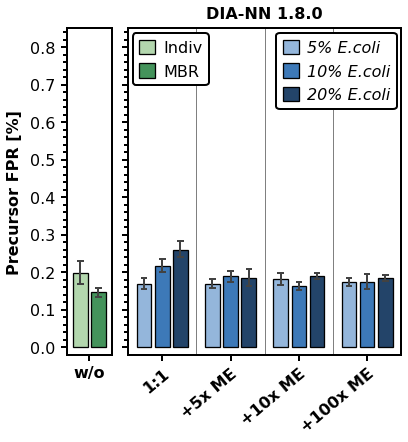

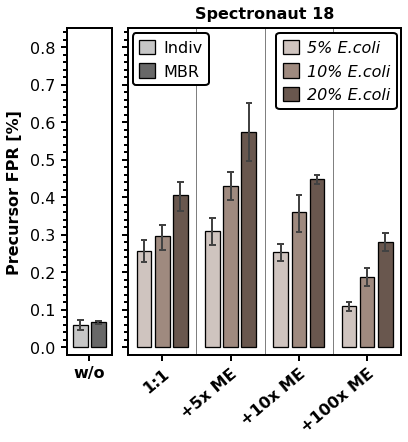

In [34]:
palette1 = ['Greens', '#88B6E7', '#2878CC', '#174475']
palette2 = ['Greys', '#D2C3BC', '#A4887A', '#6D564A']
titles = ['DIA-NN 1.8.0', 'Spectronaut 18']

for frame, palette, title in zip([dnn_fpr, spec_fpr], [palette1, palette2], titles):
    
    fig, ax = plt.subplots(1, 2, figsize=(6,6), sharey=True, gridspec_kw={'width_ratios': [1, 6]})
    plt.subplots_adjust(wspace=0.1)
    axs = fig.axes
    axs[0].set_ylim([-0.02, 0.85])

    sns.barplot(data=frame[frame['Ratio'] == 'w/o'], x='Ratio', y='FPR', hue='Condition', gap=0.2,
                palette=palette[0], capsize=0.2, edgecolor='k', linewidth=1.3, err_kws={'linewidth': 2}, ax=axs[0])

    sns.barplot(data=frame[frame['Ratio'] != 'w/o'], x='Ratio', y='FPR', hue='Spike', gap=0.2,
                palette=palette[1:4], capsize=0.2, edgecolor='k', linewidth=1.3, err_kws={'linewidth': 2}, ax=axs[1])

    for ax in axs:
        ax.set_xlabel('')
        ax.set_ylabel('')
        plt.setp(ax.get_xticklabels(), fontsize=fontsize, fontweight='bold')

        ax.minorticks_on()
        ax.tick_params(axis='both', which='major', pad=5, length=lw*3, width=lw, labelsize=fontsize)
        ax.tick_params(axis='x', which='minor', length=0)
        ax.tick_params(axis='y', which='minor', pad=5, length=lw*2, width=lw)

        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(lw)

    for i in range(3):
        axs[1].axvline(x=(i+0.5), linewidth=lw/2, color='grey')
    
    axs[0].set_ylabel('Precursor FPR [%]', fontsize=fontsize, fontweight='bold', labelpad=8)
    axs[1].set_xticklabels(['1:1', '+5x ME', '+10x ME', '+100x ME'], rotation=40, ha='right', rotation_mode='anchor')
    
    axs[0].set_zorder(2)
    handles, labels = axs[0].get_legend_handles_labels()
    legend1 = axs[0].legend(loc=(1.45,0.825), handles=handles[0:4], labels=['Indiv', 'MBR'], 
                            fontsize=fontsize, framealpha=1, handletextpad=0.5, 
                            handlelength=1, handleheight=1, edgecolor='k')
    handles, labels = axs[1].get_legend_handles_labels()
    legend2 = axs[1].legend(loc=0, handles=handles[0:4], labels=['5% E.coli', '10% E.coli', '20% E.coli'], 
                            framealpha=1, handletextpad=0.5, handlelength=1, handleheight=1, borderaxespad=0.3, 
                            edgecolor='k', prop=dict(style='italic', size=fontsize))
    legend1.get_frame().set_linewidth(lw)
    legend2.get_frame().set_linewidth(lw)
    
    axs[1].set_title(title, fontsize=fontsize, fontweight='bold', pad=10)
    
#     plt.savefig('02_Figures/Peptide_FPR_' + title.split(' ')[0] + '.png', dpi=400, bbox_inches='tight')
#     plt.savefig('02_Figures/Peptide_FPR_' + title.split(' ')[0] + '.pdf', dpi=400, bbox_inches='tight')

In [29]:
for frame_list in [dnn_peptides, spec_peptides]:
    for frame in frame_list[2:15]:  # keeping out individual and mbr 
        frame.loc[:,('new ecoli')] = frame['ECOLI'].sub(frame_list[0]['ECOLI']) # subtract ecoli from search without matching
        frame.loc[:,('new human')] = frame['HUMAN'].sub(frame_list[0]['HUMAN']) # subtract human from search without matching
        frame.loc[:,('FTR')] = frame['new ecoli'].div(frame['new ecoli'].add(frame['new human'])) *100
        
        ftr_values = frame['FTR'].to_list()
        for i, val in enumerate(ftr_values):    # FTR calculation has problems with negative values
            if frame['new ecoli'][i] < 0:
                ftr_values[i] = 0
            elif (val < 0) or (val > 100):
                ftr_values[i] = 100
            
        frame.loc[:, ('new FTR')] = ftr_values
        
dnn_ftr = pd.concat([pep[['Condition', 'Ratio', 'Spike', 'new FTR']] for pep in dnn_peptides[2:15]]).dropna()
spec_ftr = pd.concat([pep[['Condition', 'Ratio', 'Spike', 'new FTR']] for pep in spec_peptides[2:15]]).dropna()

C:\Users\k689l\AppData\Local\Temp\ipykernel_4388\2688565225.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['1:1', '+5x ME', '+10x ME', '+100x ME'], rotation=40, ha='right', rotation_mode='anchor')
C:\Users\k689l\AppData\Local\Temp\ipykernel_4388\2688565225.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(['1:1', '+5x ME', '+10x ME', '+100x ME'], rotation=40, ha='right', rotation_mode='anchor')
C:\Users\k689l\AppData\Local\Temp\ipykernel_4388\2688565225.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(['+100x ME'], rotation=40, ha='right', rotation_mode='anchor')


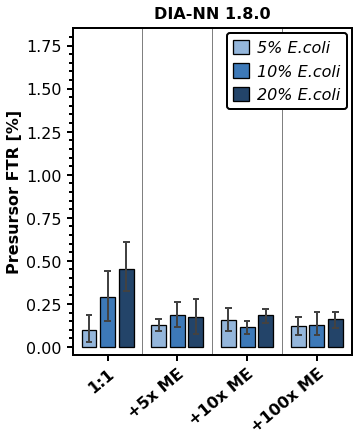

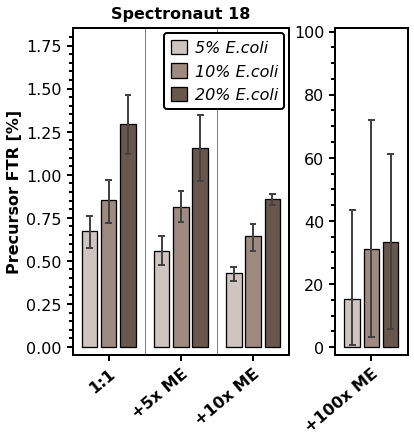

In [40]:
# for diann
fig, ax = plt.subplots(1, 1, figsize=(5,6))
ax.set_ylim([-0.044, 1.85])

sns.barplot(data=dnn_ftr[dnn_ftr['Ratio'] != 'w/o'], x='Ratio', y='new FTR', hue='Spike', gap=0.2,
            palette=palette1[1:4], capsize=0.2, edgecolor='black', linewidth=1.3, err_kws={'linewidth': 2}, ax=ax)

ax.set_xlabel('')
ax.set_ylabel('')
plt.setp(ax.get_xticklabels(), fontsize=fontsize, fontweight='bold')

ax.minorticks_on()
ax.tick_params(axis='both', which='major', direction='out', pad=5, length=lw*3, width=lw, labelsize=fontsize)
ax.tick_params(axis='x', which='minor', length=0)
ax.tick_params(axis='y', which='minor', direction='out', pad=5, length=lw*2, width=lw)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(lw)

for i in range(3):
    ax.axvline(x=(i+0.5), linewidth=lw/2, color='grey')

ax.set_ylabel('Presursor FTR [%]', fontsize=fontsize, fontweight='bold')
ax.set_xticklabels(['1:1', '+5x ME', '+10x ME', '+100x ME'], rotation=40, ha='right', rotation_mode='anchor')

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(loc=0, handles=handles[0:4], labels=['5% E.coli', '10% E.coli', '20% E.coli'], 
                   framealpha=1, handletextpad=0.5, handlelength=1, handleheight=1, borderaxespad=0.3, 
                   edgecolor='k', prop=dict(style='italic', size=fontsize))
legend.get_frame().set_linewidth(lw)

ax.set_title(titles[0], fontsize=fontsize, fontweight='bold', pad=10)

# plt.savefig('02_Figures/Peptide_FTR_' + titles[0].split(' ')[0] + '.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/Peptide_FTR_' + titles[0].split(' ')[0] + '.pdf', dpi=400, bbox_inches='tight')

# for spectronaut
fig, ax = plt.subplots(1, 2, figsize=(6,6), gridspec_kw={'width_ratios': [3,1]})
plt.subplots_adjust(wspace=0.32)
axs = fig.axes

axs[0].set_ylim([-0.044, 1.85])
axs[1].set_ylim([-2.35, 101])

data = spec_ftr[spec_ftr['Ratio'] != 'w/o']

sns.barplot(data=data[data['Ratio'] != '+100x ME'], x='Ratio', y='new FTR', hue='Spike', gap=0.2,
            palette=palette2[1:4], capsize=0.2, edgecolor='k', linewidth=1.3, err_kws={'linewidth': 2}, ax=axs[0])
sns.barplot(data=data[data['Ratio'] == '+100x ME'], x='Ratio', y='new FTR', hue='Spike', gap=0.2,
            palette=palette2[1:4], capsize=0.2, edgecolor='k', linewidth=1.3, err_kws={'linewidth': 2}, ax=axs[1])

for ax in axs:
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.setp(ax.get_xticklabels(), fontsize=fontsize, fontweight='bold')

    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', pad=5, length=lw*3, width=lw, labelsize=fontsize)
    ax.tick_params(axis='x', which='minor', length=0)
    ax.tick_params(axis='y', which='minor', pad=5, length=lw*2, width=lw)

    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(lw)

for i in range(2):
    axs[0].axvline(x=(i+0.5), linewidth=lw/2, color='grey')

axs[0].set_ylabel('Precursor FTR [%]', fontsize=fontsize, fontweight='bold')
axs[0].set_xticklabels(['1:1', '+5x ME', '+10x ME', '+100x ME'], rotation=40, ha='right', rotation_mode='anchor')
axs[1].set_xticklabels(['+100x ME'], rotation=40, ha='right', rotation_mode='anchor')

handles, labels = axs[0].get_legend_handles_labels()
legend = axs[0].legend(loc=0, handles=handles[0:4], labels=['5% E.coli', '10% E.coli', '20% E.coli'], 
                       framealpha=1, handletextpad=0.5, handlelength=1, handleheight=1, borderaxespad=0.3, 
                       edgecolor='k', prop=dict(style='italic', size=fontsize))
legend.get_frame().set_linewidth(lw)
axs[1].legend().remove()

axs[0].set_title(titles[1], fontsize=fontsize, fontweight='bold', pad=10)

# plt.savefig('02_Figures/Peptide_FTR_' + titles[1].split(' ')[0] + '.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/Peptide_FTR_' + titles[1].split(' ')[0] + '.pdf', dpi=400, bbox_inches='tight')

In [41]:
# protein-level q-value filtering
# for diann
dnn_proteins = []
for i, frame in enumerate(dnn_reports):
    
    if i == 0:
        filtered = frame[frame['Global.PG.Q.Value'] <= 0.01]
    else:
        filtered = frame[frame['Lib.PG.Q.Value'] <= 0.01]
    
    filtered = filtered[~(filtered['Organism'].str.contains('HUMAN') & filtered['Organism'].str.contains('ECOLI'))]
    filtered.loc[:,('Organism')] = [r.split(';')[0] for r in filtered['Organism']]
    
    grouped = filtered.groupby(['Run', 'Organism'])
    ec_prots, h_prots = grouped['Protein.Group'].nunique().groupby('Organism').agg(list)
    
    ec_tots, h_tots = filtered.groupby('Organism')['Protein.Group'].nunique()

    prots = pd.DataFrame(data={'ECOLI': ec_prots, 'HUMAN': h_prots, 'ECOLI_total': ec_tots, 'HUMAN_total': h_tots, 
                               'Condition': names[i]}, index=filtered['Run'].unique())
    
    if i <= 1:
        prots.loc[:,('Ratio')] = 'w/o'
        prots.loc[:,('Spike')] = ''
    if i > 1:
        prots.loc[:,('Ratio')] = names[i].split('_')[0] + 'x ME'
        prots.loc[:,('Spike')] = [r.split('_')[1] + '%' for r in prots['Condition']]
        
    prots.loc[:,('FPR')] = prots['ECOLI'].div(prots['HUMAN']) *100   
    dnn_proteins.append(prots)
    
# for spectronaut
spec_proteins = []
for i, frame in enumerate(spec_reports):
    
    filtered = frame[frame['PG.Qvalue'] <= 0.01]
    filtered = filtered[filtered['PG.QValue (Run-Wise)'] <= 0.01]
    filtered = filtered[filtered['PG.PEP'] <= 0.75]    
    
    filtered = filtered[~(filtered['Organism'].str.contains('HUMAN') & filtered['Organism'].str.contains('ECOLI'))]
    filtered.loc[:,('Organism')] = [r.split(';')[0] for r in filtered['Organism']]
    
    grouped = filtered.groupby(['R.FileName', 'Organism'])
    ec_prots, h_prots = grouped['PG.ProteinGroups'].nunique().groupby('Organism').agg(list)
    
    ec_tots, h_tots = filtered.groupby('Organism')['PG.ProteinGroups'].nunique()
        
    prots = pd.DataFrame(data={'ECOLI': ec_prots, 'HUMAN': h_prots, 'ECOLI_total': ec_tots, 'HUMAN_total': h_tots,
                               'Condition': names[i]}, index=frame['R.FileName'].unique())
    
    if i <= 1:
        prots.loc[:,('Ratio')] = 'w/o'
        prots.loc[:,('Spike')] = ''
    if i > 1:
        prots.loc[:,('Ratio')] = names[i].split('_')[0] + 'x ME'
        prots.loc[:,('Spike')] = [r.split('_')[1] + '%' for r in prots['Condition']]
        
    prots.loc[:,('FPR')] = prots['ECOLI'].div(prots['HUMAN']) *100   
    spec_proteins.append(prots)
    
dnn_prot_fpr = pd.concat([prot[['Condition', 'Ratio', 'Spike', 'FPR']] for prot in dnn_proteins])
spec_prot_fpr = pd.concat([prot[['Condition', 'Ratio', 'Spike', 'FPR']] for prot in spec_proteins])

C:\Users\k689l\AppData\Local\Temp\ipykernel_4388\710598812.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(['1:1', '+5x ME', '+10x ME', '+100x ME'], rotation=40, ha='right', rotation_mode='anchor')
C:\Users\k689l\AppData\Local\Temp\ipykernel_4388\710598812.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(['1:1', '+5x ME', '+10x ME', '+100x ME'], rotation=40, ha='right', rotation_mode='anchor')


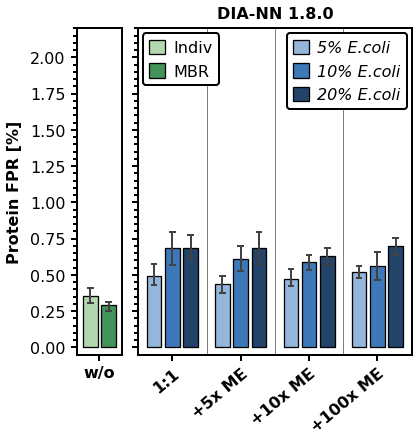

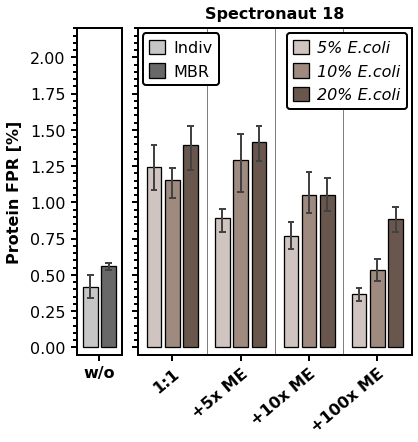

In [55]:
for frame, palette, title in zip([dnn_prot_fpr, spec_prot_fpr], [palette1, palette2], titles):
    
    fig, ax = plt.subplots(1, 2, figsize=(6,6), sharey=True, gridspec_kw={'width_ratios': [1, 6]})
    plt.subplots_adjust(wspace=0.1)
    axs = fig.axes
    axs[0].set_ylim([-0.05, 2.2])

    sns.barplot(data=frame[frame['Ratio'] == 'w/o'], x='Ratio', y='FPR', hue='Condition', gap=0.2,
                palette=palette[0], capsize=0.2, edgecolor='k', linewidth=1.3, err_kws={'linewidth': 2}, ax=axs[0])

    sns.barplot(data=frame[frame['Ratio'] != 'w/o'], x='Ratio', y='FPR', hue='Spike', gap=0.2,
                palette=palette[1:4], capsize=0.2, edgecolor='k', linewidth=1.3, err_kws={'linewidth': 2}, ax=axs[1])

    for ax in axs:
        ax.set_xlabel('')
        ax.set_ylabel('')
        plt.setp(ax.get_xticklabels(), fontsize=fontsize, fontweight='bold')

        ax.minorticks_on()
        ax.tick_params(axis='both', which='major', pad=5, length=lw*3, width=lw, labelsize=fontsize)
        ax.tick_params(axis='x', which='minor', length=0)
        ax.tick_params(axis='y', which='minor', pad=5, length=lw*2, width=lw)

        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(lw)

    for i in range(3):
        axs[1].axvline(x=(i+0.5), linewidth=lw/2, color='grey')
    
    axs[0].set_ylabel('Protein FPR [%]', fontsize=fontsize, fontweight='bold', labelpad=8)
    axs[1].set_xticklabels(['1:1', '+5x ME', '+10x ME', '+100x ME'], rotation=40, ha='right', rotation_mode='anchor')
    
    axs[0].set_zorder(2)
    handles, labels = axs[0].get_legend_handles_labels()
    legend1 = axs[0].legend(loc=(1.45,0.825), handles=handles[0:4], labels=['Indiv', 'MBR'], 
                            fontsize=fontsize, framealpha=1, borderaxespad=0.3, 
                            handletextpad=0.5, handlelength=1, handleheight=1, edgecolor='k')
    handles, labels = axs[1].get_legend_handles_labels()
    legend2 = axs[1].legend(loc=0, handles=handles[0:4], labels=['5% E.coli', '10% E.coli', '20% E.coli'], 
                            framealpha=1, borderaxespad=0.3, handletextpad=0.5, handlelength=1, handleheight=1, 
                            edgecolor='k', prop=dict(style='italic', size=fontsize))
    legend1.get_frame().set_linewidth(lw)
    legend2.get_frame().set_linewidth(lw)
    
    axs[1].set_title(title, fontsize=fontsize, fontweight='bold', pad=10)
    
#     plt.savefig('02_Figures/Protein_FPR_' + title.split(' ')[0] + '.png', dpi=400, bbox_inches='tight')
#     plt.savefig('02_Figures/Protein_FPR_' + title.split(' ')[0] + '.pdf', dpi=400, bbox_inches='tight')

In [56]:
for frame_list in [dnn_proteins, spec_proteins]:
    for frame in frame_list[2:15]:
        frame.loc[:,('new ecoli')] = frame['ECOLI'].sub(frame_list[0]['ECOLI'])
        frame.loc[:,('new human')] = frame['HUMAN'].sub(frame_list[0]['HUMAN'])
        frame.loc[:,('FTR')] = frame['new ecoli'].div(frame['new ecoli'].add(frame['new human'])) *100
        
        ftr_values = frame['FTR'].to_list()
        for i, val in enumerate(ftr_values):    # FTR calculation has problems if less human proteins were identified
            if frame['new ecoli'][i] < 0:
                ftr_values[i] = 0
            elif (val < 0) or (val > 100):
                ftr_values[i] = 100
            
        frame.loc[:, ('new FTR')] = ftr_values
        
dnn_prot_ftr = pd.concat([prot[['Condition', 'Ratio', 'Spike', 'new FTR']] for prot in dnn_proteins[2:15]]).dropna()
spec_prot_ftr = pd.concat([prot[['Condition', 'Ratio', 'Spike', 'new FTR']] for prot in spec_proteins[2:15]]).dropna()

C:\Users\k689l\AppData\Local\Temp\ipykernel_4388\2458927987.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['1:1', '+5x ME', '+10x ME', '+100x ME'], rotation=40, ha='right', rotation_mode='anchor')
C:\Users\k689l\AppData\Local\Temp\ipykernel_4388\2458927987.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(['1:1', '+5x ME', '+10x ME', '+100x ME'], rotation=40, ha='right', rotation_mode='anchor')
C:\Users\k689l\AppData\Local\Temp\ipykernel_4388\2458927987.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(['+100x ME'], rotation=40, ha='right', rotation_mode='anchor')


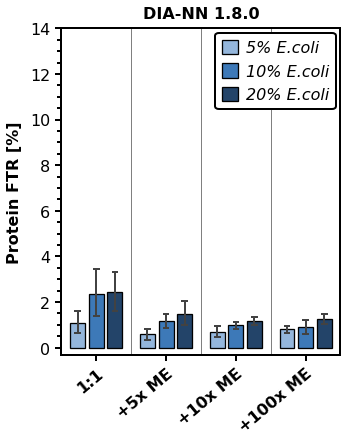

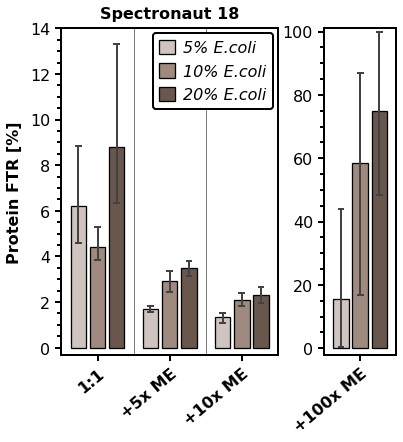

In [59]:
# for diann
fig, ax = plt.subplots(1, 1, figsize=(5,6))
ax.set_ylim([-0.3, 14])

sns.barplot(data=dnn_prot_ftr[dnn_prot_ftr['Ratio'] != 'w/o'], x='Ratio', y='new FTR', hue='Spike', gap=0.2,
            palette=palette1[1:4], capsize=0.2, edgecolor='k', linewidth=1.3, err_kws={'linewidth': 2}, ax=ax)

ax.set_xlabel('')
ax.set_ylabel('')
plt.setp(ax.get_xticklabels(), fontsize=fontsize, fontweight='bold')

ax.minorticks_on()
ax.tick_params(axis='both', which='major', pad=5, length=lw*3, width=lw, labelsize=fontsize)
ax.tick_params(axis='x', which='minor', length=0)
ax.tick_params(axis='y', which='minor', pad=5, length=lw*2, width=lw)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(lw)

for i in range(3):
    ax.axvline(x=(i+0.5), linewidth=lw/2, color='grey')

ax.set_ylabel('Protein FTR [%]', fontsize=fontsize, fontweight='bold', labelpad=8)
ax.set_xticklabels(['1:1', '+5x ME', '+10x ME', '+100x ME'], rotation=40, ha='right', rotation_mode='anchor')

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(loc=0, handles=handles[0:4], labels=['5% E.coli', '10% E.coli', '20% E.coli'], 
                   framealpha=1, borderaxespad=0.3, handletextpad=0.5, handlelength=1, handleheight=1, 
                   edgecolor='k', prop=dict(style='italic', size=fontsize))
legend.get_frame().set_linewidth(lw)

ax.set_title(titles[0], fontsize=fontsize, fontweight='bold', pad=10)
    
# plt.savefig('02_Figures/Protein_FTR_' + titles[0].split(' ')[0] + '.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/Protein_FTR_' + titles[0].split(' ')[0] + '.pdf', dpi=400, bbox_inches='tight')

# for spectronaut
fig, ax = plt.subplots(1, 2, figsize=(6,6), gridspec_kw={'width_ratios': [3,1]})
plt.subplots_adjust(wspace=0.32)
axs = fig.axes

axs[0].set_ylim([-0.3, 14])
axs[1].set_ylim([-2, 101])

data = spec_prot_ftr[spec_prot_ftr['Ratio'] != 'w/o']

sns.barplot(data=data[data['Ratio'] != '+100x ME'], x='Ratio', y='new FTR', hue='Spike', gap=0.2,
            palette=palette2[1:4], capsize=0.2, edgecolor='k', linewidth=1.3, err_kws={'linewidth': 2}, ax=axs[0])
sns.barplot(data=data[data['Ratio'] == '+100x ME'], x='Ratio', y='new FTR', hue='Spike', gap=0.2,
            palette=palette2[1:4], capsize=0.2, edgecolor='k', linewidth=1.3, err_kws={'linewidth': 2}, ax=axs[1])

for ax in axs:
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.setp(ax.get_xticklabels(), fontsize=fontsize, fontweight='bold')

    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', pad=5, length=lw*3, width=lw, labelsize=fontsize)
    ax.tick_params(axis='x', which='minor', length=0)
    ax.tick_params(axis='y', which='minor', pad=5, length=lw*2, width=lw)

    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(lw)

for i in range(2):
    axs[0].axvline(x=(i+0.5), linewidth=lw/2, color='grey')

axs[0].set_ylabel('Protein FTR [%]', fontsize=fontsize, fontweight='bold', labelpad=8)
axs[0].set_xticklabels(['1:1', '+5x ME', '+10x ME', '+100x ME'], rotation=40, ha='right', rotation_mode='anchor')
axs[1].set_xticklabels(['+100x ME'], rotation=40, ha='right', rotation_mode='anchor')

handles, labels = axs[0].get_legend_handles_labels()
legend = axs[0].legend(loc=0, handles=handles[0:4], labels=['5% E.coli', '10% E.coli', '20% E.coli'], 
                framealpha=1, borderaxespad=0.3, handletextpad=0.5, handlelength=1, handleheight=1, 
                edgecolor='k', prop=dict(style='italic', size=fontsize))
legend.get_frame().set_linewidth(lw)
axs[1].legend().remove()

axs[0].set_title(titles[1], fontsize=fontsize, fontweight='bold', pad=10)

# plt.savefig('02_Figures/Protein_FTR_' + titles[1].split(' ')[0] + '.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/Protein_FTR_' + titles[1].split(' ')[0] + '.pdf', dpi=400, bbox_inches='tight')

C:\Users\k689l\AppData\Local\Temp\ipykernel_14060\1765052266.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[j].set_xticklabels(['Indiv', 'MBR', '1:1', '+5x ME', '+10x ME', '+100x ME'], fontweight='bold',
E:\KK\03_Programs\Anaconda3\lib\site-packages\seaborn\categorical.py:3398: UserWarning: 28.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\k689l\AppData\Local\Temp\ipykernel_14060\1765052266.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[j].set_xticklabels(['Indiv', 'MBR', '1:1', '+5x ME', '+10x ME', '+100x ME'], fontweight='bold',
C:\Users\k689l\AppData\Local\Temp\ipykernel_14060\1765052266.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[j].set_xticklabels(['Indiv', 'MBR', '1:1', '+5x ME', '+10x ME', '+100x ME'], fontweight='bold',
E:\KK\03_Programs\Anaconda3\lib\site-pack

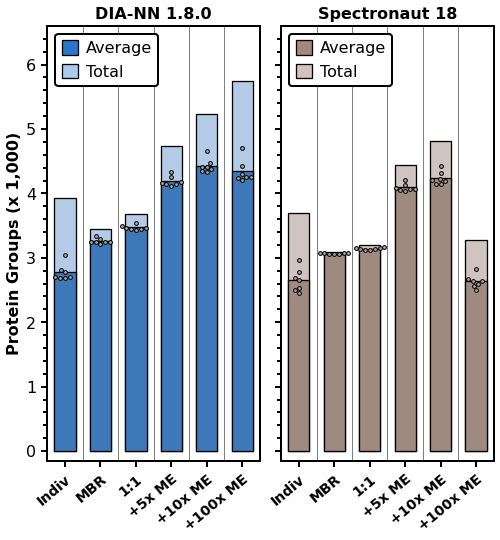

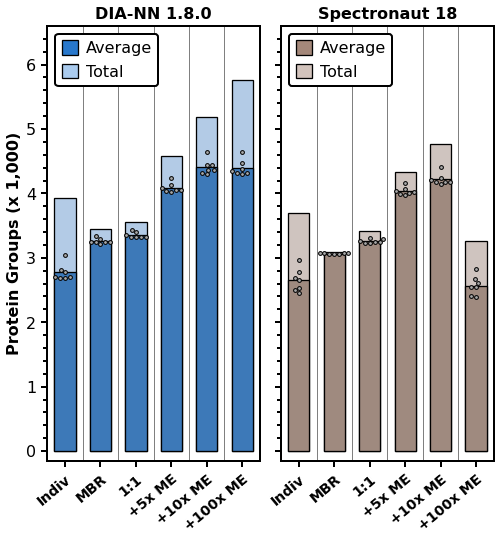

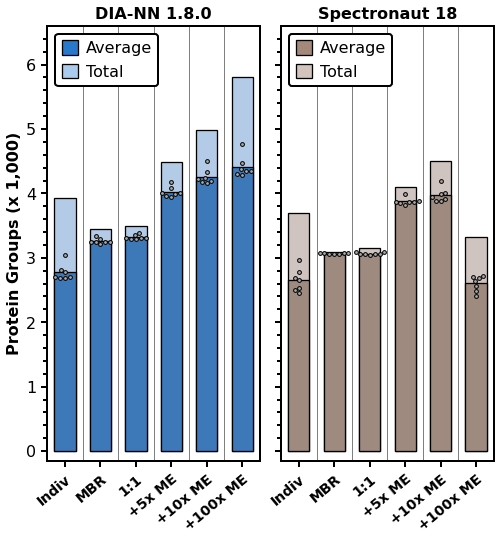

In [99]:
# human protein numbers
dnn_prot_nrs = pd.concat([prot[['Condition', 'Ratio', 'Spike', 'HUMAN', 'HUMAN_total']] for prot in dnn_proteins]).dropna()
spec_prot_nrs = pd.concat([prot[['Condition', 'Ratio', 'Spike', 'HUMAN', 'HUMAN_total']] for prot in spec_proteins]).dropna()

colors = [palette1[2], palette2[2]]
colors2 = ['#AACBEE', palette2[1]]

for i, spike in enumerate(dnn_prot_nrs['Spike'].unique()):
    
    if i > 0:  # searches without MEs dont have a spike
        fig, ax = plt.subplots(1, 2, figsize=(8,8), sharey=True)
        plt.subplots_adjust(wspace=0.1)

        for j, frame in enumerate([dnn_prot_nrs, spec_prot_nrs]):

            data = frame[frame['Spike'].isin(['', spike])] # appending searches without MEs to each spike ratio figure   
            sns.barplot(data=data, x='Condition', y=data['HUMAN_total']/1000, color=colors2[j], edgecolor='black', 
                        linewidth=1.3, errorbar=None, width=0.6, ax=ax[j])
            sns.barplot(data=data, x='Condition', y=data['HUMAN']/1000, color=colors[j], edgecolor='black', 
                        linewidth=1.3, errorbar=None, width=0.6, ax=ax[j])
            sns.swarmplot(data=data, x='Condition', y=data['HUMAN']/1000, color='darkgrey', edgecolor='black',
                          size=3.8, linewidth=1, ax=ax[j])
            
            ax[j].minorticks_on()
            ax[j].tick_params(axis='both', which='major', direction='out', pad=5, length=lw*3, width=lw, labelsize=fontsize)
            ax[j].tick_params(axis='x', which='minor', length=0)
            ax[j].tick_params(axis='y', which='minor', direction='out', pad=5, length=lw*2, width=lw)
            
            ax[j].set_title(titles[j], fontsize=fontsize, fontweight='bold', pad=7)
            ax[j].set_ylim([-0.15, 6.6])
            ax[j].set_xlabel('')
            ax[j].set_ylabel('Protein Groups (x 1,000)', fontsize=fontsize, fontweight='bold')
            ax[j].set_xticklabels(['Indiv', 'MBR', '1:1', '+5x ME', '+10x ME', '+100x ME'], fontweight='bold', 
                                  fontsize=fontsize-2, rotation=40, ha='right', rotation_mode='anchor')

            for axis in ['top', 'bottom', 'left', 'right']:
                ax[j].spines[axis].set_linewidth(lw)

            for i in range(5):
                ax[j].axvline(x=(i+0.5), linewidth=lw/2, color='grey')
            
            pa1 = mpl.patches.Patch(facecolor=colors[j], edgecolor='black', linewidth=1.3)
            pa2 = mpl.patches.Patch(facecolor=colors2[j], edgecolor='black', linewidth=1.3)
            
            legend = ax[j].legend(handles=[pa1, pa2], labels=['Average', 'Total'],
                                  ncol=1, handletextpad=0.5, handlelength=1, handleheight=1,
                                  loc=2, framealpha=1, edgecolor='black', fontsize=fontsize)
            legend.get_frame().set_linewidth(lw)
            
#         plt.savefig('02_Figures/Protein_Number_Softwares_' + spike + '-spike.png', dpi=400, bbox_inches='tight')
#         plt.savefig('02_Figures/Protein_Number_Softwares_' + spike + '-spike.pdf', dpi=400, bbox_inches='tight')

In [131]:
# put ROC curves here based on Perseus analysis

NameError: name 'dnn_reports' is not defined